In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import dateutil.parser
from pandas import DataFrame

import warnings
warnings.filterwarnings('ignore')

import time

import dask.dataframe as dd
from dask import delayed

In [2]:
romero_path = "/home/nromerodiaz93/Documents/Universidad/JI/Carlos/Parameters/Yo/datos completos.csv"

In [3]:
# Importamos los datos
data = %time pd.read_csv(romero_path, parse_dates=[2], sep=',', na_values='NA',low_memory=False)

CPU times: user 3.73 s, sys: 377 ms, total: 4.11 s
Wall time: 4.1 s


In [4]:
data.head()

,Unnamed: 0,name,times,type,value,size,condcode
0,1,BBVACOL CB Equity,2017-03-03 09:30:00,BID,0.0,0.0,NaN
1,2,BBVACOL CB Equity,2017-03-03 09:30:00,ASK,0.0,0.0,NaN
2,3,BBVACOL CB Equity,2017-03-03 09:30:00,ASK,295.0,30890.0,NaN
3,4,BBVACOL CB Equity,2017-03-03 09:30:00,ASK,295.0,75244.0,NaN
4,5,BBVACOL CB Equity,2017-03-03 09:30:00,BID,255.0,17660.0,NaN


# Manejo de datos

In [5]:
# Funcion que genera un DataFrame con todos los dias (sin repetir) de los cuales tenemos datos

def GetDate(stockdata):
    '''
    Parameters:
    ------
    stockdata:
    DataFrame - Data of various stocks
    
    Return:
    ------
    days: DataFrame - DataFrame of all days for which there is data
    '''
    
    days = pd.DatetimeIndex(stockdata.index).normalize()
    days = pd.DataFrame(days)
    days.index = stockdata.index
    days.columns = ['dia']
    
    return days.drop_duplicates(keep='first').dia

In [6]:
# Funcion que inicializa las columnas: 'nombre', 'date_time', 'tipo', 'precio', 'volumen',
#                                      'BID', 'ASK', 'Mid_Price', 'Quoted_Spread'

def StockPreprocessing(stockdata, stock_ticker):
    '''
    Parameters:
    ------
    stockdata:
    DataFrame - Data of various stocks
    
    stock_ticker:
    String - Ticker of the stock we are interested in
    
    
    Return:
    ------
    stockdata:
    DataFrame - Data of stocks with the folloeing initialized columns: 
    nombre', 'date_time', 'tipo', 'precio', 'volumen', 'BID', 'ASK', 'Mid_Price', 'Quoted_Spread'
    '''
    
    stockname = stock_ticker + " CB Equity"
    
    #Se cambian los nombres de las columnas y se elimina lo demas
    stockdata = stockdata[['name', 'times', 'type', 'value', 'size']]
    stockdata.columns=['nombre','date_time','tipo','precio','volumen']      
    stockdata = stockdata[['nombre','date_time','tipo','precio','volumen']]
    
    
    #Se seleccionan los datos segun la accion y el horario que nos interesan
    stockdata = stockdata.loc[(stockdata["nombre"] == stockname)]
    stockdata.index = stockdata.date_time
    stockdata = stockdata.between_time('9:30','15:55')
    stockdata['dia'] = pd.DatetimeIndex(stockdata.date_time).normalize() 
    
    days = GetDate(stockdata)#.drop_duplicates(keep='first').dia
    
    BA = []
    
    for i in days:
        stockdailydata = stockdata[stockdata.dia == str(i)]
        
        init_values = stockdailydata.precio.values
        d = {'BID': init_values, 'ASK': init_values}
        BA_df = pd.DataFrame(data=d)
        #BA_df.index = stockdata.index
        
        bid = stockdailydata['tipo'] == 'BID'
        ask = stockdailydata['tipo'] == 'ASK'
        BA_df.BID = np.multiply(bid.values, stockdailydata.precio.values)
        BA_df.ASK = np.multiply(ask.values, stockdailydata.precio.values)
        
        #BA_df['BID'].replace(to_replace = 0, method = 'ffill')
        #BA_df['ASK'].replace(to_replace = 0, method = 'ffill')
        BA_df['BID'] = BA_df['BID'].replace(to_replace = 0, method = 'ffill').values
        BA_df['ASK'] = BA_df['ASK'].replace(to_replace = 0, method = 'ffill').values
        
        BA_df = BA_df.where(BA_df.BID <= BA_df.ASK, np.nan) #np.nan
        
        BA_df['Mid_price']     = 0.5*(BA_df['BID'].values + BA_df['ASK'].values)
        BA_df['Quoted_Spread'] = (BA_df['ASK'].values - BA_df['BID'].values)/(BA_df.Mid_price.values)
            
        #BA_df.index = stockdailydata.index
        
        BA.append(BA_df)
    
    BA = pd.concat(BA, axis=0)
    BA.index = stockdata.index
    stockdata = pd.concat([stockdata, BA], axis=1)
        
    return stockdata

## Evaluación
---
Evaluamos la función `StockPreprocessing()` para la acción ECOPETL

In [7]:
# Aplicamos nuestra funcion
prep_data = %time StockPreprocessing(data, 'ECOPETL')

CPU times: user 1.38 s, sys: 27.8 ms, total: 1.41 s
Wall time: 1.41 s


In [8]:
prep_data.head()

,nombre,date_time,tipo,precio,volumen,dia,BID,ASK,Mid_price,Quoted_Spread
date_time,,,,,,,,,,
2017-03-03 09:30:00,ECOPETL CB Equity,2017-03-03 09:30:00,ASK,1320.0,360000.0,2017-03-03,0.0,1320.0,660.0,2.000000
2017-03-03 09:30:00,ECOPETL CB Equity,2017-03-03 09:30:00,BID,1305.0,100000.0,2017-03-03,1305.0,1320.0,1312.5,0.011429
2017-03-03 09:30:02,ECOPETL CB Equity,2017-03-03 09:30:02,ASK,1315.0,80000.0,2017-03-03,1305.0,1315.0,1310.0,0.007634
2017-03-03 09:30:03,ECOPETL CB Equity,2017-03-03 09:30:03,ASK,1315.0,155240.0,2017-03-03,1305.0,1315.0,1310.0,0.007634
2017-03-03 09:30:12,ECOPETL CB Equity,2017-03-03 09:30:12,BID,1305.0,170000.0,2017-03-03,1305.0,1315.0,1310.0,0.007634


# Paralelización
---
Vamos a evaluar las funciones en paralelo para los parámetros de profundidad. Primero, definimos una función que nos retorne una lista. Cada entrada de este lista corresponde a los datos de un día en particular. El primer elemento de esta es el DataFrame de los datos del 3/03/2017, y la última entrada corresponde al DataFrame de los datos del 31/08/2017.

In [9]:
def sep_date(stockdata):
    days = GetDate(stockdata)
    daily_dfs = []
    for i in days:
        daily_dfs.append(stockdata.loc[stockdata["dia"] == i])
    return daily_dfs

In [10]:
test = sep_date(prep_data)
test[0].head()

,nombre,date_time,tipo,precio,volumen,dia,BID,ASK,Mid_price,Quoted_Spread
date_time,,,,,,,,,,
2017-03-03 09:30:00,ECOPETL CB Equity,2017-03-03 09:30:00,ASK,1320.0,360000.0,2017-03-03,0.0,1320.0,660.0,2.000000
2017-03-03 09:30:00,ECOPETL CB Equity,2017-03-03 09:30:00,BID,1305.0,100000.0,2017-03-03,1305.0,1320.0,1312.5,0.011429
2017-03-03 09:30:02,ECOPETL CB Equity,2017-03-03 09:30:02,ASK,1315.0,80000.0,2017-03-03,1305.0,1315.0,1310.0,0.007634
2017-03-03 09:30:03,ECOPETL CB Equity,2017-03-03 09:30:03,ASK,1315.0,155240.0,2017-03-03,1305.0,1315.0,1310.0,0.007634
2017-03-03 09:30:12,ECOPETL CB Equity,2017-03-03 09:30:12,BID,1305.0,170000.0,2017-03-03,1305.0,1315.0,1310.0,0.007634


In [11]:
len(test)

119

**Ahora:** Vamos a definir una función decorada con `@delay` para que calcule los parámetros de profundidad para *un único día*. Luego, insertamos esta función dentro de otra función para que compute los resultados en paralelo.

In [12]:
@delayed
def DailyDepth(stockdailydata):
    
    # Creamos columnas para las variables de profundidad
    init_values = np.zeros( np.shape(stockdailydata)[0] )
    #vol = stockdailydata.volumen
    stockdailydata = stockdailydata.assign(**{'BID_depth': init_values, 'ASK_depth': init_values,
                          'Depth': init_values, 'log_depth': init_values})
    
    for j in range(1, np.shape(stockdailydata)[0] ):
        
        #Tipo BID
        if(stockdailydata.tipo[j]=="BID"):
            stockdailydata.ASK_depth[j] = stockdailydata.ASK_depth[j-1]     
            if(stockdailydata.precio[j] == stockdailydata.BID[j]):     
                if(stockdailydata.precio[j] == stockdailydata.BID[j-1]):
                    stockdailydata.BID_depth[j] = stockdailydata.BID_depth[j-1] + stockdailydata.volumen[j]
                elif(stockdailydata.precio[j] != stockdailydata.BID[j-1]):
                    stockdailydata.BID_depth[j] = stockdailydata.volumen[j]
            elif(stockdailydata.precio[j] != stockdailydata.BID[j]):
                stockdailydata.BID_depth[j] = stockdailydata.BID_depth[j-1]   
                    
        #Tipo ASK
        elif(stockdailydata.tipo[j]=="ASK"):
            stockdailydata.BID_depth[j] = stockdailydata.BID_depth[j-1]       
            if(stockdailydata.precio[j] == stockdailydata.ASK[j]):
                if(stockdailydata.precio[j] == stockdailydata.ASK[j-1]):
                    stockdailydata.ASK_depth[j] = stockdailydata.ASK_depth[j-1] + stockdailydata.volumen[j]
                elif(stockdailydata.precio[j] != stockdailydata.ASK[j-1]):
                    stockdailydata.ASK_depth[j] = stockdailydata.volumen[j]
            elif(stockdailydata.precio[j] != stockdailydata.ASK[j]):
                stockdailydata.ASK_depth[j] = stockdailydata.ASK_depth[j-1]
                
        #Tipo TRADE
        elif(stockdailydata.tipo[j]=="TRADE"):
            if(stockdailydata.precio[j] == stockdailydata.ASK[j]):
                stockdailydata.BID_depth[j] = stockdailydata.BID_depth[j-1]
                stockdailydata.ASK_depth[j] = stockdailydata.ASK_depth[j-1] - stockdailydata.volumen[j]
            elif(stockdailydata.precio[j] == stockdailydata.BID[j]):
                stockdailydata.BID_depth[j] = stockdailydata.BID_depth[j-1] - stockdailydata.volumen[j]
                stockdailydata.ASK_depth[j] = stockdailydata.ASK_depth[j-1]
            else:
                stockdailydata.BID_depth[j] = stockdailydata.BID_depth[j-1]
                stockdailydata.ASK_depth[j] = stockdailydata.ASK_depth[j-1]
                
    print("Comienzan a revisarse las condiciones")
    
    # Eliminamos los datos que no tienen sentido
    for k in range(np.shape(stockdailydata)[0]):
        if( stockdailydata.BID_depth[k] < 0):
            stockdailydata.BID_depth[k] = 0
            
        if( stockdailydata.ASK_depth[k] < 0):
            stockdailydata.ASK_depth[k] = 0
            
        # Se calcula la profundidad
        stockdailydata.Depth[k] = stockdailydata.BID_depth[k] + stockdailydata.ASK_depth[k]
        
        # Se calcula la log-profundidad
        if(stockdailydata.ASK_depth[k] != 0 and stockdailydata.BID_depth[k] != 0):
            stockdailydata.log_depth[k] = np.log(stockdailydata.BID_depth[k] * stockdailydata.ASK_depth[k])
            
    # Se quitan los NaN de los datos de profundidad
    for l in range(0, len(stockdailydata.tipo)):   
        if (np.isnan(stockdailydata.Quoted_Spread[l]) == True): 
            stockdailydata.BID_depth[l] = 0
            stockdailydata.ASK_depth[l] = 0
            stockdailydata.Depth[l]     = 0
            stockdailydata.log_depth[l] = 0
            
    return stockdailydata

In [13]:
daily = sep_date(prep_data)
del_df = []

Comienzan a revisarse las condiciones
Tiempo total: -1.5189626892407735 minutos


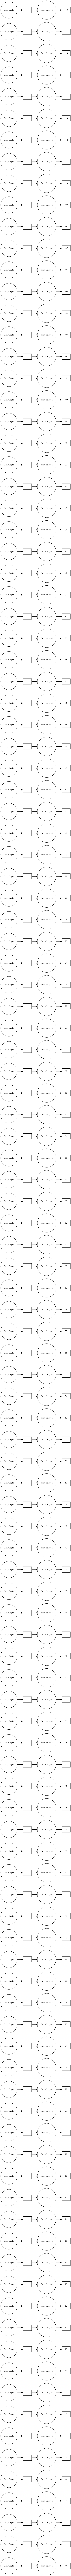

In [14]:
t_start = time.time()

for df in daily:
    del_df.append(DailyDepth(df))
    
dask_df = dd.from_delayed(del_df)

print("Tiempo total:", ((t_start-time.time())/60), "minutos" )

dask_df.visualize(rankdir="LR")

**Ahora:** Vamos a definir la tercera y última función. Esta combina las dos funciones anteriores para separar los datos en datos diarios y para calcular en paralelo los parámetros de profundidad.

In [15]:
%time dask_df.compute()

Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a revisarse las condiciones
Comienzan a 

,nombre,date_time,tipo,precio,volumen,dia,BID,ASK,Mid_price,Quoted_Spread,BID_depth,ASK_depth,Depth,log_depth
date_time,,,,,,,,,,,,,,
2017-03-03 09:30:00,ECOPETL CB Equity,2017-03-03 09:30:00,ASK,1320.0,360000.0,2017-03-03,0.0,1320.0,660.0,2.000000,0.0,0.0,0.0,0.000000
2017-03-03 09:30:00,ECOPETL CB Equity,2017-03-03 09:30:00,BID,1305.0,100000.0,2017-03-03,1305.0,1320.0,1312.5,0.011429,100000.0,0.0,100000.0,0.000000
2017-03-03 09:30:02,ECOPETL CB Equity,2017-03-03 09:30:02,ASK,1315.0,80000.0,2017-03-03,1305.0,1315.0,1310.0,0.007634,100000.0,80000.0,180000.0,22.802707
2017-03-03 09:30:03,ECOPETL CB Equity,2017-03-03 09:30:03,ASK,1315.0,155240.0,2017-03-03,1305.0,1315.0,1310.0,0.007634,100000.0,235240.0,335240.0,23.881287
2017-03-03 09:30:12,ECOPETL CB Equity,2017-03-03 09:30:12,BID,1305.0,170000.0,2017-03-03,1305.0,1315.0,1310.0,0.007634,270000.0,235240.0,505240.0,24.874539
2017-03-03 09:30:14,ECOPETL CB Equity,2017-03-03 09:30:14,ASK,1315.0,153240.0,2017-03-03,1305.0,1315.0,1310.0,0.007634,270000.0,388480.0,658480.0,25.376174
2017-03-03 09:30:14,ECOPETL CB Equity,2017-03-03 09:30:14,TRADE,1315.0,2000.0,2017-03-03,1305.0,1315.0,1310.0,0.007634,270000.0,386480.0,656480.0,25.371013
2017-03-03 09:30:22,ECOPETL CB Equity,2017-03-03 09:30:22,BID,1305.0,169000.0,2017-03-03,1305.0,1315.0,1310.0,0.007634,439000.0,386480.0,825480.0,25.857090
2017-03-03 09:30:22,ECOPETL CB Equity,2017-03-03 09:30:22,TRADE,1305.0,1000.0,2017-03-03,1305.0,1315.0,1310.0,0.007634,438000.0,386480.0,824480.0,25.854810


In [18]:
dask_df.shape

(Delayed('int-e396729f-07f3-4eaa-b166-f0c7199fe9cb'), 14)

# En resumen:
---
Ya viendo que el procedimiento funciona, resumimos los pasos seguidos en la siguiente función: `StockDepth()`

In [19]:
def StockDepth(stockdata):
    daily_df = sep_date(stockdata)
    delayed_dfs = []
    
    for df in daily_df:
        delayed_dfs.append( DailyDepth(df) )
        
    result_df = dd.from_delayed(delayed_dfs)
    return result_df.compute()

# Fin del examen

# Buy-Sell

In [20]:
def InitiatingParty(stockdata):
    '''
    Parameters:
    ------
    stockdata:
    DataFrame - Data of the stock
    
    Return:
    ------
    x:
    DataFrame - DataFrame of TRADE quotes with the party that initiated the trade
    '''
    
    x = stockdata[stockdata.tipo == 'TRADE']
    
    # +1: transaccion iniciada por comprador
    buyer  = x.precio.values > x.Mid_price.values
    
    # -1: transaccion iniciada por vendedor
    seller = x.precio.values < x.Mid_price.values
    
    x['iniciado'] = buyer.astype(int) - seller.astype(int)
    x['iniciado'] = x['iniciado'].replace(to_replace = 0, method = 'ffill').values
    
    return x

## Evaluación
---
Evaluamos la función `InitiatingParty()` para la acción ECOPETL

In [21]:
tst = InitiatingParty(prep_data)
tst.tail(10)

,nombre,date_time,tipo,precio,volumen,dia,BID,ASK,Mid_price,Quoted_Spread,iniciado
date_time,,,,,,,,,,,
2017-08-31 15:48:57,ECOPETL CB Equity,2017-08-31 15:48:57,TRADE,1365.0,37061.0,2017-08-31,1360.0,1365.0,1362.5,0.00367,1
2017-08-31 15:49:35,ECOPETL CB Equity,2017-08-31 15:49:35,TRADE,1365.0,3794.0,2017-08-31,1360.0,1365.0,1362.5,0.00367,1
2017-08-31 15:49:35,ECOPETL CB Equity,2017-08-31 15:49:35,TRADE,1365.0,396206.0,2017-08-31,1360.0,1365.0,1362.5,0.00367,1
2017-08-31 15:49:52,ECOPETL CB Equity,2017-08-31 15:49:52,TRADE,1365.0,100000.0,2017-08-31,1360.0,1365.0,1362.5,0.00367,1
2017-08-31 15:50:22,ECOPETL CB Equity,2017-08-31 15:50:22,TRADE,1360.0,1000.0,2017-08-31,1360.0,1365.0,1362.5,0.00367,-1
2017-08-31 15:51:50,ECOPETL CB Equity,2017-08-31 15:51:50,TRADE,1360.0,1214.0,2017-08-31,1360.0,1365.0,1362.5,0.00367,-1
2017-08-31 15:54:15,ECOPETL CB Equity,2017-08-31 15:54:15,TRADE,1365.0,3794.0,2017-08-31,1360.0,1365.0,1362.5,0.00367,1
2017-08-31 15:54:15,ECOPETL CB Equity,2017-08-31 15:54:15,TRADE,1365.0,12278.0,2017-08-31,1360.0,1365.0,1362.5,0.00367,1
2017-08-31 15:54:35,ECOPETL CB Equity,2017-08-31 15:54:35,TRADE,1360.0,1000.0,2017-08-31,1360.0,1365.0,1362.5,0.00367,-1


# Price impact

In [22]:
from datetime import timedelta
from sklearn import linear_model as lm
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [23]:
def ImpactParameters(stockdata):
    days = GetDate(stockdata)#.drop_duplicates(keep='first').dia
    res = []
    
    for i in days:
        stockdailydata = stockdata[stockdata.dia == str(i)]
        
        stockdailydata['delta_p']    = stockdailydata['precio'].diff()
        stockdailydata['order_flow'] = stockdailydata.volumen.values * stockdailydata.iniciado.values
        
        res.append(stockdailydata)
        
    res_df = pd.concat(res, axis=0)
    return res_df

In [24]:
def KyleImpactRegression(stockdata):
    
    days = GetDate(stockdata)#.drop_duplicates(keep='first').dia
    res = []
    
    for i in days:
        
        stockdailydata = stockdata[stockdata.dia == str(i)]
        
        x1 = stockdailydata.delta_p.values
        x1 = x1.reshape(-1, 1)
        
        x2 = stockdailydata.order_flow.values
        x2 = sm.add_constant(x2.reshape(-1, 1))
        
        result = sm.OLS(x1, x2, missing='drop').fit()
        
        coef = result.params[1]
        pvalue = result.pvalues[1]
        trades = len(stockdailydata)
        
        temp = [i, coef, pvalue, trades]
        res.append(temp)
        
    #res = pd.DataFrame(res, columns=['day', 'reg_coefficient', 'p_value', 'trades'])
    res = pd.DataFrame(res, columns=['dia', 'coef_regresion', 'p_value', 'trades'])
    res = res.set_index('dia')
    
    return res

## Evaluación
---
Evaluamos las funciones `ImpactParameters()` y `KyleImpactRegression()` para la acción ECOPETL

In [25]:
etet = ImpactParameters(tst)
etet.tail()

,nombre,date_time,tipo,precio,volumen,dia,BID,ASK,Mid_price,Quoted_Spread,iniciado,delta_p,order_flow
date_time,,,,,,,,,,,,,
2017-08-31 15:51:50,ECOPETL CB Equity,2017-08-31 15:51:50,TRADE,1360.0,1214.0,2017-08-31,1360.0,1365.0,1362.5,0.00367,-1,0.0,-1214.0
2017-08-31 15:54:15,ECOPETL CB Equity,2017-08-31 15:54:15,TRADE,1365.0,3794.0,2017-08-31,1360.0,1365.0,1362.5,0.00367,1,5.0,3794.0
2017-08-31 15:54:15,ECOPETL CB Equity,2017-08-31 15:54:15,TRADE,1365.0,12278.0,2017-08-31,1360.0,1365.0,1362.5,0.00367,1,0.0,12278.0
2017-08-31 15:54:35,ECOPETL CB Equity,2017-08-31 15:54:35,TRADE,1360.0,1000.0,2017-08-31,1360.0,1365.0,1362.5,0.00367,-1,-5.0,-1000.0
2017-08-31 15:54:37,ECOPETL CB Equity,2017-08-31 15:54:37,TRADE,1360.0,3235.0,2017-08-31,1360.0,1365.0,1362.5,0.00367,-1,0.0,-3235.0


In [26]:
tretre = KyleImpactRegression(etet)
tretre.head()

,coef_regresion,p_value,trades
dia,,,
2017-03-03,1.884887e-07,7.937333e-01,176
2017-03-06,7.987430e-06,7.632925e-02,277
2017-03-07,1.599549e-06,2.831874e-01,243
2017-03-08,4.147077e-06,3.137254e-02,377
2017-03-09,1.280608e-05,9.602215e-08,289


# Resultados
---
Guardamos los resultados obtenidos al aplicar este código en el archivo csv `optim_results.csv`